In [1]:
from utilities import * 
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%load_ext autoreload
%autoreload 2
nest_asyncio.apply()

df1_path = '../dataset/raw/nist/azure_cleaned.csv'
df2_path = '../dataset/raw/nist/aws_cleaned.csv'

keys_path = '../dataset/raw/nist/keys'

dataset_name_or_path = "../dataset/training/nist_form"
model_name='google/flan-t5-base' # google/flan-t5-large


output_path = '../dataset/raw/nist/donut-tt-gpt_ver1.csv'

In [2]:
from datasets import load_dataset
import torch
import time
import evaluate
import pandas as pd
import numpy as np
import ast


from transformers import (AutoModelForSeq2SeqLM, 
                          AutoTokenizer, 
                          GenerationConfig, 
                          TrainingArguments,
                          Trainer,
                          EarlyStoppingCallback,
                          IntervalStrategy)

from peft import (LoraConfig,
                  get_peft_model,
                  TaskType,
                  PeftModel,
                  PeftConfig)


## FR:

In [3]:
df1 = pd.read_csv(df1_path)
df1.fillna('None', inplace=True)
print(df1.shape)
df1.head()

(2100, 9)


,image_name,DATE,DATE_CONFIDENCE,CITY,CITY_CONFIDENCE,STATE,STATE_CONFIDENCE,ZIP,ZIP_CONFIDENCE
0,f0194_30.png,08/08/89,0.991,"HUNTINGTON BON,",0.287,CA,0.172,92648,None
1,f1421_27.png,08/28/89,0.093,None,None,None,None,None,None
2,f1954_31.png,9-26-89,0.759,RHINELANDER,0.862,Wisconsin,0.976,54501,None
3,f0891_44.png,None,None,Aug 23 1989\nCentral Falls,0.838,KI,0.325,02863,None
4,f1574_26.png,09/16/89,0.823,ALAMOGORDO,0.139,NM,0.86,88350,None


## TT result:

In [4]:
df2 = pd.read_csv(df2_path)
df2.fillna('None', inplace=True)
print(df2.shape)
df2.head()

(2100, 9)


,image_name,DATE,DATE__CONFIDENCE,CITY,CITY__CONFIDENCE,STATE,STATE_CONFIDENCE,ZIP,ZIP_CONFIDENCE
0,f0000_14.png,08/02/89,88.97464,FLiNT,86.739792,Mi,80.102089,48504,73.823257
1,f0001_41.png,8-7-89,87.28508,Allendale,89.946899,MI,82.12265,49401,77.600266
2,f0002_01.png,8-3-89,81.038841,MINDEN CITY,80.873611,mi,35.721474,48456,37.457157
3,f0003_42.png,08-03-89,87.377403,Charlotte,80.985222,MI,77.612007,48813,71.598038
4,f0004_09.png,08-03-89,89.594048,Holland,80.345238,Mi,62.762756,49424,58.702671


# Load ground truth:

In [9]:
len(dataset)

3

In [5]:
dataset = load_dataset(dataset_name_or_path)
dataset

Resolving data files:   0%|          | 0/1401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/501 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/sohrab/.cache/huggingface/datasets/imagefolder/nist_form-732fcc5960300798/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 199
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 500
    })
})

## Load model

In [11]:
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, 
                                                       device_map="auto",
                                                       torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto",)

In [12]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"""trainable model parameters: {trainable_model_params}
                \nall model parameters: {all_model_params}
                \npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"""

print(print_number_of_trainable_model_parameters(original_model))

trainable model parameters: 247577856
                
all model parameters: 247577856
                
percentage of trainable model parameters: 100.00%


In [13]:
def tokenize_function(batch):
    
    # Create containers for input_ids and labels for the entire batch
    input_ids_list = []
    labels_list = []

    # Iterate over each example in the batch
    for idx in range(len(batch["ground_truth"])):
        
        ground_truth = str(json.loads(batch["ground_truth"][idx])['gt_parse'])
        file_path = batch['image'][idx].filename
        input_image_name = f"{file_path[file_path.rfind('/')+1: ]}"

        df_1 = df1[df1.image_name == input_image_name]
        df_2 = df2[df2.image_name == input_image_name]
        
        # make sure they both JSONS have all the keys
        json1 = init_json(df_1)
        json2 = init_json(df_2)

         
        prompt = f"""convert the two input JSONs delimited by triple backticks into one OUTPUT_JSON.\n\n

         INPUT_JSONS: ```
         JSON1 = {json1}, 
         JSON2 = {json2}``` 
         
         \n\nOUTPUT_JSON:  
        """
        
        # Tokenize and append to the batch lists
        input_ids_list.append(tokenizer(prompt, padding="max_length", truncation=True).input_ids)
        labels_list.append(tokenizer(ground_truth, padding="max_length", truncation=True).input_ids)
    
    batch['input_ids'] = input_ids_list
    batch['labels'] = labels_list
    
    
    # Convert lists to tensors
    return batch

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['ground_truth', 'image'])

Loading cached processed dataset at /home/sohrab/.cache/huggingface/datasets/imagefolder/nist_form-732fcc5960300798/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-9f7702827a1f36ad.arrow
Loading cached processed dataset at /home/sohrab/.cache/huggingface/datasets/imagefolder/nist_form-732fcc5960300798/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-857c3ca0584bc26a.arrow
Loading cached processed dataset at /home/sohrab/.cache/huggingface/datasets/imagefolder/nist_form-732fcc5960300798/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-abafacfee18518c3.arrow


In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 199
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
})

In [11]:
output_dir = f'../result/t5-{str(int(time.time()))}'

training_args = TrainingArguments(
    output_dir=output_dir,
    do_eval= True,
    learning_rate=1e-5,
    num_train_epochs=40,
    weight_decay=0.01,
    logging_steps=1,
#     max_steps=200
)

trainer = Trainer(
    model=original_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation']
)

In [11]:
trainer.train()

/home/sohrab/anaconda3/envs/ocr37/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1400
  Num Epochs = 40
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7000
  Number of trainable parameters = 247577856


Step,Training Loss
1,56.250000
2,55.750000
3,56.500000
4,54.750000
5,56.500000
6,57.000000
7,55.750000
8,56.000000
9,56.750000
10,52.250000


Saving model checkpoint to ../result/t5-1695550327/checkpoint-500
Configuration saved in ../result/t5-1695550327/checkpoint-500/config.json
Model weights saved in ../result/t5-1695550327/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ../result/t5-1695550327/checkpoint-1000
Configuration saved in ../result/t5-1695550327/checkpoint-1000/config.json
Model weights saved in ../result/t5-1695550327/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ../result/t5-1695550327/checkpoint-1500
Configuration saved in ../result/t5-1695550327/checkpoint-1500/config.json
Model weights saved in ../result/t5-1695550327/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to ../result/t5-1695550327/checkpoint-2000
Configuration saved in ../result/t5-1695550327/checkpoint-2000/config.json
Model weights saved in ../result/t5-1695550327/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ../result/t5-1695550327/checkpoint-2500
Configuration saved in ../result/t5-16955503

TrainOutput(global_step=7000, training_loss=8.690116071428571, metrics={'train_runtime': 11829.0997, 'train_samples_per_second': 4.734, 'train_steps_per_second': 0.592, 'total_flos': 3.8346411737088e+16, 'train_loss': 8.690116071428571, 'epoch': 40.0})

## Test model:

In [40]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained("../result/t5-1695550327/checkpoint-7000",
                                                       device_map="auto",
                                                       torch_dtype=torch.bfloat16)

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 199
    })
    test: Dataset({
        features: ['image', 'ground_truth'],
        num_rows: 500
    })
})

In [41]:
index = 200


ground_truth = str(json.loads(dataset['test']["ground_truth"][index])['gt_parse'])
ground_truth

"{'DATE': '8-19-89', 'CITY': 'CHICAGO', 'STATE': 'IL', 'ZIP': '60619'}"

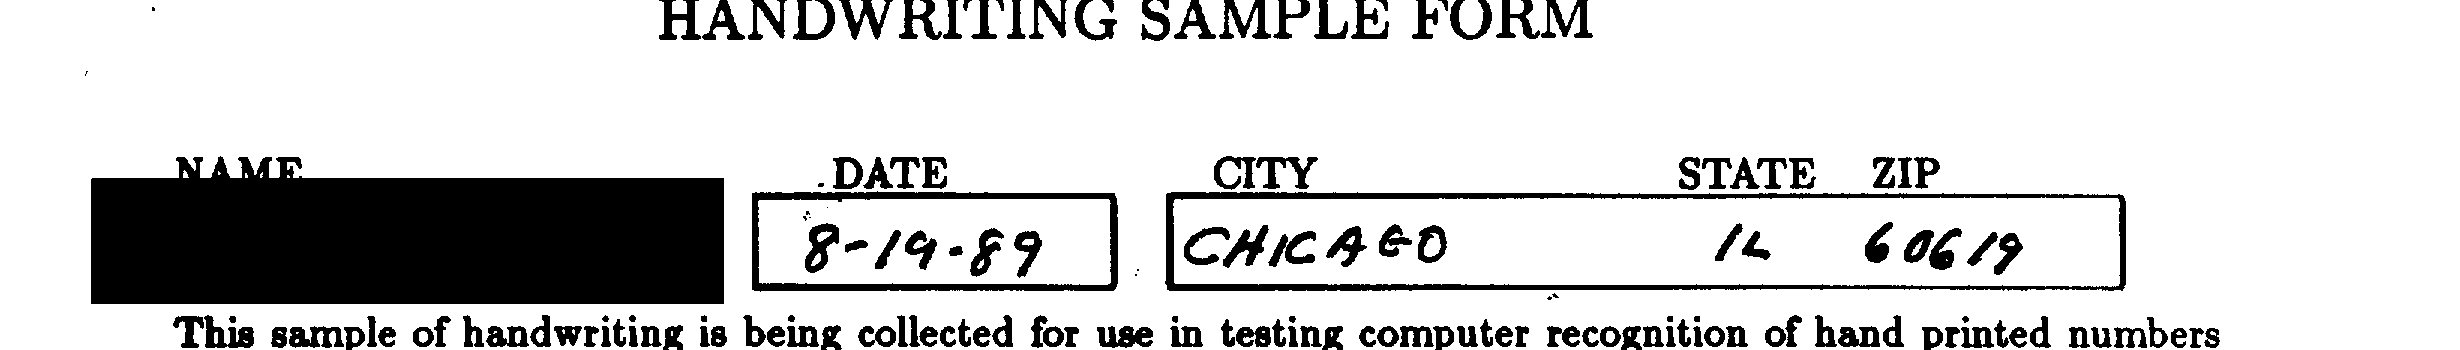

In [42]:
dataset['test']['image'][index]

In [156]:
index = 10


ground_truth = str(json.loads(dataset['test']["ground_truth"][index])['gt_parse'])

file_path = dataset['test']['image'][index].filename
input_image_name = f"{file_path[file_path.rfind('/')+1: ]}"

df_1 = df1[df1.image_name == input_image_name]
df_2 = df2[df2.image_name == input_image_name]

# make sure they both JSONS have all the keys
json1 = init_json(df_1)
json2 = init_json(df_2)


prompt = f"""convert the two input JSONs delimited by triple backticks into one OUTPUT_JSON.

         INPUT_JSONS: ```
         JSON1 = {json1}, 
         JSON2 = {json2}```
         
         OUTPUT_JSON = 
        """
    
input_ids = tokenizer(prompt, return_tensors="pt").input_ids

In [157]:
json2, json1

({'DATE': '8/2/89', 'CITY': 'TOLEDO', 'STATE': 'Ohio', 'ZIP': '43608'},
 {'DATE': '8/2/89', 'CITY': 'TOLEDO', 'STATE': 'Oh10', 'ZIP': '43608'})

In [135]:
len(input_ids[0])

161

In [136]:
instruct_model_outputs = instruct_model.generate(input_ids=input_ids, 
                                                 generation_config=GenerationConfig(max_new_tokens=200, 
                                                                                    num_beams=3))
instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], 
                                              skip_special_tokens=True)

In [137]:
instruct_model_text_output

'TOLEDO_STATE_Ohio_ZIP: 43608'

In [138]:
json1, json2, ground_truth, instruct_model_text_output

({'DATE': '8/2/89', 'CITY': 'TOLEDO', 'STATE': 'Oh10', 'ZIP': '43608'},
 {'DATE': '8/2/89', 'CITY': 'TOLEDO', 'STATE': 'Ohio', 'ZIP': '43608'},
 "{'DATE': '8/2/89', 'CITY': 'TOLEDO', 'STATE': 'Ohio', 'ZIP': '43608'}",
 'TOLEDO_STATE_Ohio_ZIP: 43608')

In [90]:
dataset_name_or_path = "../dataset/training/nist_form"
dataset = load_dataset(dataset_name_or_path)

In [96]:
dataset = load_dataset(dataset_name_or_path)

Resolving data files:   0%|          | 0/1401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/200 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/501 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/sohrab/.cache/huggingface/datasets/imagefolder/nist_form-732fcc5960300798/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [93]:
file_path = dataset['image'][index]

In [94]:
file_path.filename

'/home/sohrab/projects/hvdu/src/dataset/training/nist_form/test/f0049_32.png'

## Setup the PEFT/LoRA model for Fine-Tuning

You need to set up the PEFT/LoRA model for fine-tuning with a new layer/parameter adapter. Using PEFT/LoRA, you are freezing the underlying LLM and only training the adapter. Have a look at the LoRA configuration below. Note the rank (`r`) hyper-parameter, which defines the rank/dimension of the adapter to be trained.

In [58]:
lora_config = LoraConfig(
    r=256, # Rank
    lora_alpha=256,
    target_modules=["q", "v"],
    lora_dropout=0.025,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)


# lora_config = LoraConfig(
#     r=64, # Rank
#     lora_alpha=64,
#     target_modules=["q", "v"],
#     lora_dropout=0.15,
#     bias="none",
#     task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
# )


In [59]:
peft_model = get_peft_model(original_model, 
                            lora_config)
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 28311552
                
all model parameters: 275889408
                
percentage of trainable model parameters: 10.26%


In [60]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1400
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 199
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 500
    })
})

In [61]:
output_dir = f'../result/t5-lora-{str(int(time.time()))}'


# peft_training_args = TrainingArguments(
#     output_dir=output_dir,
#     auto_find_batch_size=True,
#     learning_rate=1e-3, # Higher learning rate than full fine-tuning.
#     num_train_epochs=1,
#     logging_steps=1,
#     max_steps=500   
# )
    
# peft_trainer = Trainer(
#     model=peft_model,
#     args=peft_training_args,
#     train_dataset=tokenized_datasets["train"],
# )

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True,
    learning_rate=1e-3,
#     weight_decay=0.01,
    num_train_epochs=3,
    logging_steps=1,
#     max_steps=500,
    load_best_model_at_end=True,
    eval_steps = 50,
    save_total_limit = 5,
    evaluation_strategy = IntervalStrategy.STEPS,
)
    
peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

peft_trainer.train()

/home/sohrab/anaconda3/envs/orc37/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss
50,0.074700,0.032348
100,0.031100,0.020272
150,0.026500,0.017452
200,0.028800,0.016480
250,0.030400,0.015086
300,0.031100,0.014837
350,0.022200,0.014543
400,0.022500,0.014016
450,0.029100,0.013738
500,0.032000,0.013798


TrainOutput(global_step=525, training_loss=0.3938427734375, metrics={'train_runtime': 901.2733, 'train_samples_per_second': 4.66, 'train_steps_per_second': 0.583, 'total_flos': 3241267848806400.0, 'train_loss': 0.3938427734375, 'epoch': 3.0})

In [62]:
peft_model_path=f'../result/t5-peft-{str(int(time.time()))}'
print(peft_model_path)

peft_trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

pd.DataFrame(peft_trainer.state.log_history).to_csv(f'{peft_model_path}/log_history.csv', index = False)

../result/t5-peft-1696011704


In [63]:
pd.DataFrame(peft_trainer.state.log_history)

,loss,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,57.2500,0.000998,0.01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33.2500,0.000996,0.01,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23.8750,0.000994,0.02,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17.2500,0.000992,0.02,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0625,0.000990,0.03,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
531,0.0210,0.000006,2.98,522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
532,0.0170,0.000004,2.99,523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,0.0260,0.000002,2.99,524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,0.0134,0.000000,3.00,525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# best model so far 1695734927
peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base",
                                                        device_map="auto", 
                                                        torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       peft_model_path, 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)

In [65]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
                
all model parameters: 275889408
                
percentage of trainable model parameters: 0.00%


In [66]:
# %%time
# instruct_model_outputs = peft_model.generate(input_ids=input_ids, 
#                                                  generation_config=GenerationConfig(max_new_tokens=200, 
#                                                                                     num_beams=2))
# instruct_model_text_output = tokenizer.decode(instruct_model_outputs[0], 
#                                               skip_special_tokens=True)

### Evaluation 

In [67]:
dataset_ = dataset['test']
dataset_

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 500
})

In [68]:
def fix_string_v1(data_str):
    
    keys = ["DATE", "CITY", "STATE", "ZIP"]

    # 1. Fix stray single quotes in values
    for key in keys:
        pattern_stray_quotes = r"'{}': '([^']+)''([^']+?)'".format(key)
        replacement_stray_quotes = r"'{}': '\1\2'".format(key)
        data_str = re.sub(pattern_stray_quotes, replacement_stray_quotes, data_str)

    # 2. Fix missing closing quotes
    for key in keys:
        pattern_missing_closing = r"'{}': '([^']+?)((?=, '{}':)|(?=, '{}':)|(?=, '{}':)|(?=, '{}':)|$)".format(key, *keys)
        replacement_missing_closing = r"'{}': '\1'".format(key)
        data_str = re.sub(pattern_missing_closing, replacement_missing_closing, data_str)

    # 3. Ensure all values are enclosed in single quotes
    for i, key in enumerate(keys[:-1]):
        next_key = keys[i+1]
        pattern_no_quotes = r"'{}': ([^'{{,\d][^,]*)(?=, '{}'|'.*?':|$)".format(key, next_key)
        replacement_no_quotes = r"'{}': '\1'".format(key)
        data_str = re.sub(pattern_no_quotes, replacement_no_quotes, data_str)

    # Replace single quotes with double quotes to make it valid JSON
    json_str = data_str.replace("'", '"')

    # Load the fixed string
    data_dict = json.loads('{' + json_str + '}')

    return data_dict

def fix_string_v2(data_str):
    
    keys = ["DATE", "CITY", "STATE", "ZIP"]

    # 1. Fix values that might end prematurely due to a stray single quote.
    for key in keys:
        pattern_stray_quotes = r"'{}': ([^']+)'(?=, '{}':|'.*?':|$)".format(key, keys[keys.index(key) + 1] if key != "ZIP" else "ZIP")
        replacement_stray_quotes = r"'{}': '\1'".format(key)
        data_str = re.sub(pattern_stray_quotes, replacement_stray_quotes, data_str)
    
    # 2. Fix missing opening quotes
    for i, key in enumerate(keys[:-1]):
        next_key = keys[i+1]
        pattern_no_quotes = r"'{}': ([^'{{,\d][^,]*)(?=, '{}'|'.*?':|$)".format(key, next_key)
        replacement_no_quotes = r"'{}': '\1'".format(key)
        data_str = re.sub(pattern_no_quotes, replacement_no_quotes, data_str)

    # Convert single quotes to double quotes to form valid JSON string.
    json_str = data_str.replace("'", '"')

    # Parse the fixed string into a dictionary
    data_dict = json.loads('{' + json_str + '}')

    return data_dict

def fix_string_v3(data_str):
    # Fixing stray characters within the quotes for ZIP (e.g., '282'0' -> '2820')
    pattern_stray_chars = r"'ZIP': '([^']+?)'([^',]+?)'"
    replacement_stray_chars = r"'ZIP': '\1\2'"
    data_str = re.sub(pattern_stray_chars, replacement_stray_chars, data_str)

    # Convert single quotes to double quotes to form a valid JSON string.
    json_str = data_str.replace("'", '"')
    
    # Parse the fixed string into a dictionary
    data_dict = json.loads('{' + json_str + '}')
    
    return data_dict

def fix_string_v4(data_str):
    # Fixing apostrophes within the CITY value (e.g., 'Lee's Summit' -> 'Lee\'s Summit')
    pattern_apostrophe = r"'CITY': '([^']+?)'([^',]+?)'"
    replacement_apostrophe = r"'CITY': '\1\2'"
    data_str = re.sub(pattern_apostrophe, replacement_apostrophe, data_str)

    # Convert single quotes to double quotes to form a valid JSON string.
    json_str = data_str.replace("'", '"')
    
    # Parse the fixed string into a dictionary
    data_dict = json.loads('{' + json_str + '}')
    
    return data_dict


In [69]:
ground_truth_list = []
result_list = []
error_list = []
for _, sample in tqdm(enumerate(dataset_), total=len(dataset_)):
    
    file_path = sample['image'].filename
    file_name = f"{file_path[file_path.rfind('/')+1: ]}"

    ground_truth = json.loads(sample["ground_truth"])['gt_parse']
    ground_truth['image_name'] = file_name
    ground_truth_list.append(ground_truth)
    
    
    df_1 = df1[df1.image_name == file_name]
    df_2 = df2[df2.image_name == file_name]
    
    
    # make sure they both JSONS have all the keys
    json1 = init_json(df_1)
    json2 = init_json(df_2)

    
    prompt = f"""convert the two input JSONs delimited by triple backticks into one OUTPUT_JSON.

         INPUT_JSONs: ```
         JSON1 = {json1}, 
         JSON2 = {json2}```
         
         OUTPUT_JSON = 
        """

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to('cuda')
    
    instruct_model_outputs = peft_model.generate(input_ids=input_ids, 
                                                 generation_config=GenerationConfig(max_new_tokens=200, 
                                                                                    num_beams=2))
    data_str = tokenizer.decode(instruct_model_outputs[0], 
                                                  skip_special_tokens=True)
    
    try:
        data_dict = fix_string_v1 (data_str)
        data_dict['image_name'] = file_name
        result_list.append(data_dict)
            
    except:
        try:
            data_dict = fix_string_v2 (data_str)
            data_dict['image_name'] = file_name
            result_list.append(data_dict)
        except:
            try:
                data_dict = fix_string_v3 (data_str)
                data_dict['image_name'] = file_name
                result_list.append(data_dict)
            except:
                try:
                    data_dict = fix_string_v4 (data_str)
                    data_dict['image_name'] = file_name
                    result_list.append(data_dict)
                except:
                    error_list.append(file_path)
            
   
    

100%|█████████████████████████████████████████| 500/500 [15:58<00:00,  1.92s/it]


In [70]:
len(result_list)

500

In [71]:
df1_ = pd.DataFrame(result_list)
print(df1_.shape)
df1_.head()

(500, 5)


,DATE,CITY,STATE,ZIP,image_name
0,08/02/89,FLiNT,Mi,48504,f0000_14.png
1,8-7-89,Allendale,MI,49401,f0001_41.png
2,08-03-89,Holland,Mi,49424,f0004_09.png
3,8/3/89,ST. CLAIR SHORES,MI.,48082,f0006_12.png
4,8/2/89,EAST LANSING,MiCHIGAN,48823,f0009_06.png


In [72]:
df2_ = pd.DataFrame(ground_truth_list)
print(df2_.shape)
df2_.head()

(500, 5)


,DATE,CITY,STATE,ZIP,image_name
0,08/02/89,FLINT,Mi,48504,f0000_14.png
1,8-7-89,Allendale,MI,49401,f0001_41.png
2,08-03-89,Holland,Mi,49424,f0004_09.png
3,8/3/89,ST.CLAIR SHORES,MI,48082,f0006_12.png
4,8/2/89,EAST LANSING,MiCHIGAN,48823,f0009_06.png


In [73]:
def get_accuracy_dict (df, keys_path ):
    
    dict_list = []
    error_list = []

    for file_name in df.image_name:
        try:
            # get filename and the corresponding json
            json_name = file_name[file_name.rfind('/')+1: file_name.rfind('.')]

            # covert azure data to a dict
            dict1 = df[df.image_name == file_name][['DATE', 'CITY','STATE', 'ZIP']].iloc[0].to_dict()

            # open the manually cleaned corresponding json
            with open(f"{keys_path}/{json_name}.json") as f:
                dict2 = json.load(f)

            dict_list.append(dict_distance_key(dict1, dict2, file_name))

        except:
            error_list.append(file_name)
    len(error_list)
    
    return dict_list, error_list

In [74]:
dict_list, error_list  = get_accuracy_dict (df1_, keys_path)

In [75]:
df_ = pd.DataFrame(dict_list)
print(df_.shape)
df_.head()

(500, 9)


,image_name,DATE,DATE_LEN,CITY,CITY_LEN,STATE,STATE_LEN,ZIP,ZIP_LEN
0,f0000_14.png,0,8,1,5,0,2,0,5
1,f0001_41.png,0,6,0,9,0,2,0,5
2,f0004_09.png,0,8,0,7,0,2,0,5
3,f0006_12.png,0,6,1,16,1,3,0,5
4,f0009_06.png,0,6,0,12,0,8,0,5


In [76]:
df_['total_accuracy'], df_['date_accuracy'], df_['city_accuracy'], df_['state_accuracy'] , df_['zip_accuracy']  = zip(*df_.apply(lambda x: key_based_accuracy(x["DATE"],
                                                      x["CITY"],
                                                      x["STATE"],
                                                      x["ZIP"],

                                                      x["DATE_LEN"],
                                                      x["CITY_LEN"],
                                                      x["STATE_LEN"],
                                                      x["ZIP_LEN"],


                                                ), axis=1))

In [77]:
df_result_key = df_.describe()
df_result_key

,DATE,DATE_LEN,CITY,CITY_LEN,STATE,STATE_LEN,ZIP,ZIP_LEN,total_accuracy,date_accuracy,city_accuracy,state_accuracy,zip_accuracy
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.090000,7.618000,0.512000,8.414000,0.370000,3.172000,0.166000,5.004000,95.673139,99.020809,94.661019,89.516825,96.919048
std,0.449783,1.780566,1.430366,2.627625,1.038874,1.749439,0.792275,0.477955,8.438796,4.802879,14.230787,24.576970,14.579268
min,0.000000,3.000000,0.000000,4.000000,0.000000,2.000000,0.000000,4.000000,46.428571,55.555556,11.111111,0.000000,0.000000
25%,0.000000,7.000000,0.000000,6.000000,0.000000,2.000000,0.000000,5.000000,95.454545,100.000000,100.000000,100.000000,100.000000
50%,0.000000,7.000000,0.000000,8.000000,0.000000,2.000000,0.000000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000
75%,0.000000,8.000000,0.000000,10.000000,0.000000,4.000000,0.000000,5.000000,100.000000,100.000000,100.000000,100.000000,100.000000
max,4.000000,14.000000,12.000000,20.000000,10.000000,14.000000,7.000000,10.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [78]:
fla = df_[df_.total_accuracy == 100].shape[0]/df_.shape[0]
fla

0.598

In [56]:
result_dict = {}
result_dict['fla_test'] = np.round(fla, 4)*100

result_dict['CBA TOTAL TEST DATASET'] = np.round(df_result_key['total_accuracy']['mean'], 4)
result_dict['CBA DATE TEST DATASET'] = np.round(df_result_key['date_accuracy']['mean'], 4)
result_dict['CBA CITY TEST DATASET'] = np.round(df_result_key['city_accuracy']['mean'], 4)
result_dict['CBA STATE TEST DATASET'] = np.round(df_result_key['state_accuracy']['mean'], 4)
result_dict['CBA ZIP TEST DATASET'] = np.round(df_result_key['zip_accuracy']['mean'], 4)

result_dict

{'fla_test': 58.4,
 'CBA TOTAL TEST DATASET': 95.3425,
 'CBA DATE TEST DATASET': 99.0333,
 'CBA CITY TEST DATASET': 93.9169,
 'CBA STATE TEST DATASET': 89.7413,
 'CBA ZIP TEST DATASET': 96.779}

In [122]:
result_dict = {}
result_dict['fla_test'] = np.round(fla, 4)*100

result_dict['CBA TOTAL TEST DATASET'] = np.round(df_result_key['total_accuracy']['mean'], 4)
result_dict['CBA DATE TEST DATASET'] = np.round(df_result_key['date_accuracy']['mean'], 4)
result_dict['CBA CITY TEST DATASET'] = np.round(df_result_key['city_accuracy']['mean'], 4)
result_dict['CBA STATE TEST DATASET'] = np.round(df_result_key['state_accuracy']['mean'], 4)
result_dict['CBA ZIP TEST DATASET'] = np.round(df_result_key['zip_accuracy']['mean'], 4)

result_dict

{'fla_test': 59.8,
 'CBA TOTAL TEST DATASET': 95.6731,
 'CBA DATE TEST DATASET': 99.0208,
 'CBA CITY TEST DATASET': 94.661,
 'CBA STATE TEST DATASET': 89.5168,
 'CBA ZIP TEST DATASET': 96.919}